Check the tensorflow version

In [1]:
import tensorflow as tf 
print(tf.__version__) 

2.2.0-rc2


Import all neceassry libraries

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D,  MaxPooling2D, Embedding,Flatten, GlobalAveragePooling2D,TimeDistributed, Dropout, RNN, LSTM,BatchNormalization,Reshape,InputLayer,Convolution2D,Lambda
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile
import random
import shutil
from shutil import copyfile
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


Obtain the Dataset

In [3]:
#shutil.rmtree('/tmp/Task.zip')
!wget --no-check-certificate \
"https://codeload.github.com/SukhpreetKhangura/Task/zip/master" \
    -O "/tmp/Task.zip"

zip_ref = zipfile.ZipFile("/tmp/Task.zip", 'r')
zip_ref.extractall("/tmp/Task")
zip_ref_src = zipfile.ZipFile("/tmp/Task/Task-master/src_images.zip", 'r')
zip_ref_src.extractall("/tmp")
zip_ref.close()
zip_ref_src.close()

--2020-04-13 10:57:52--  https://codeload.github.com/SukhpreetKhangura/Task/zip/master
Resolving codeload.github.com (codeload.github.com)... 140.82.113.9
Connecting to codeload.github.com (codeload.github.com)|140.82.113.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘/tmp/Task.zip’

/tmp/Task.zip           [     <=>            ]   6.48M  3.95MB/s    in 1.6s    

2020-04-13 10:57:55 (3.95 MB/s) - ‘/tmp/Task.zip’ saved [6795852]



Explore the source directory

In [4]:
source_dir="/tmp/src_images/random/"
print(len(os.listdir(source_dir)))
label_fnames = os.listdir( source_dir )
print(label_fnames)

100
['horses2.jpg', 'flowers19.jpg', 'flowers5.jpg', 'flowers15.jpg', 'horses9.jpg', 'flowers18.jpg', 'dogs13.jpg', 'houses13.jpg', 'flowers11.jpg', 'horses4.jpg', 'horses5.jpg', 'flowers1.jpg', 'roads8.jpg', 'dogs1.jpg', 'horses3.jpg', 'horses14.jpg', 'houses14.jpg', 'roads7.jpg', 'dogs5.jpg', 'horses10.jpg', 'dogs7.jpg', 'dogs4.jpg', 'horses20.jpg', 'houses10.jpg', 'roads3.jpg', 'flowers2.jpg', 'roads19.jpg', 'roads5.jpg', 'horses16.jpg', 'flowers13.jpg', 'horses19.jpg', 'flowers10.jpg', 'houses9.jpg', 'horses18.jpg', 'horses15.jpg', 'roads12.jpg', 'roads20.jpg', 'roads16.jpg', 'houses16.jpg', 'roads2.jpg', 'houses18.jpg', 'houses12.jpg', 'horses8.jpg', 'flowers17.jpg', 'houses4.jpg', 'flowers12.jpg', 'flowers9.jpg', 'houses19.jpg', 'roads17.jpg', 'flowers4.jpg', 'roads13.jpg', 'dogs17.jpg', 'roads6.jpg', 'dogs6.jpg', 'roads18.jpg', 'houses2.jpg', 'roads14.jpg', 'flowers20.jpg', 'horses17.jpg', 'dogs10.jpg', 'flowers8.jpg', 'houses17.jpg', 'roads1.jpg', 'horses12.jpg', 'dogs14.jpg', 

Defining the Data Parameters

In [0]:
patch_size= (64,64) #(128,128)#(256,256) # Define patch size (64,64)#

num_patches=5 # Define number of patches per image
noise_factor = 0.5# Defined  for Gaussian noise
training_portion=.8

Depending upon the number of patches obtained per image, we will adjust our filenames list.

In [6]:
fnames=[]
for names in label_fnames:
  for i in range(num_patches):
    fnames.append(names)
print(len(fnames))

500


Model Configuration

In [0]:
img_width, img_height = patch_size
batch_size = 5 # We are using fixed batch-size to be fed to RNN
num_epochs = 100
units=patch_size[0]
seq_len=num_patches
output_shape=(seq_len,patch_size[0],patch_size[0],1)

## Preprocessing functions



1. GrayScale Conversion
2. Random Patch Extraction of (256,256)
   1. Creating five same patches to generate a sequence.
3. Normalization of Images

In [0]:
def grayscale_patches(src_dir, patch_size, num_patches_per_img):
    fnames= os.listdir( src_dir )
    image_patches=[]

    for name in fnames:
            full_name = os.path.join(src_dir, name)
            #print(full_name) # For debugging
            img = Image.open(full_name).convert('L')    #GrayScale Conversion
            patches = []
            
            for patch in range(num_patches_per_img):
                    seed=np.random.seed(0)
                    start = (np.random.rand(2) * (img.width - patch_size[1],   #Random Patch Extraction of (256,256)
                                img.height -patch_size[0])).astype('int')
                    end = start + (patch_size[1], patch_size[0])
                    patches= (tf.keras.preprocessing.image.img_to_array(img.crop((start[0], start[1],
                                                  end[0], end[1]))))

                    image_patches.append(patches)
    image_patches= np.array(image_patches, dtype=np.float)/255.   # Normalization of Images
    
    return image_patches

In [9]:
src_patches=[]
src_patches=grayscale_patches(source_dir,(patch_size[0],patch_size[1]),num_patches)
print(src_patches.shape)


(500, 64, 64, 1)


Plot original image patches extracted randomly. Per image we are extracting one random patch.


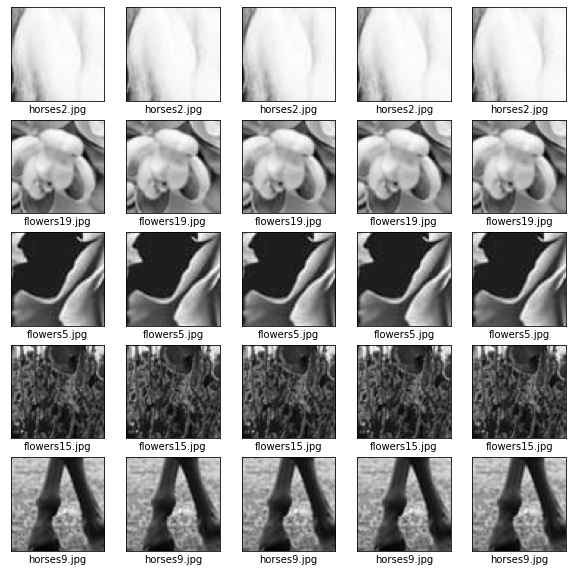

In [10]:
plt.figure(figsize=(10,10))
for i in range(25):
    src_image = src_patches[i,:,:]
    src_image = np.squeeze(src_image)
    plt.subplot(5,5,i+1)

    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(src_image, cmap='gray')
    plt.xlabel(fnames[i])
plt.show()

Add **Gaussian** **noise** to each patch independently for generating the **input**

In [11]:
noisy_src_patches=[]
noisy_src_patches = src_patches + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=src_patches.shape)
noisy_src_patches = np.clip(noisy_src_patches, 0., 1.)
print(noisy_src_patches.shape )

(500, 64, 64, 1)


Plot noisy patches

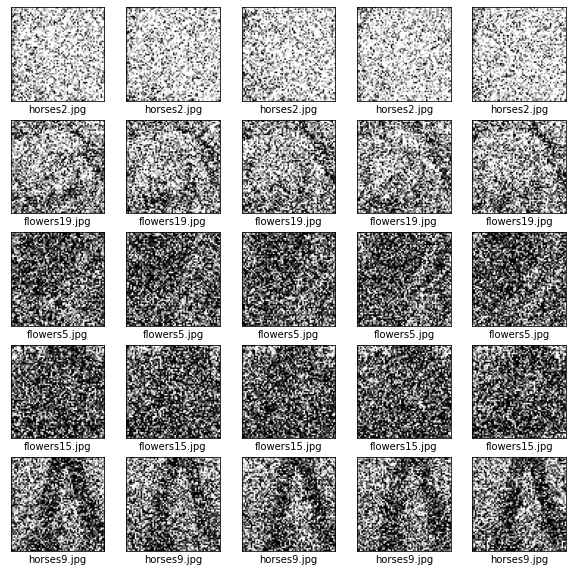

In [12]:
plt.figure(figsize=(10,10))
for i in range(25):
    noisy_src_image = noisy_src_patches[i,:,:]
    noisy_src_image = np.squeeze(noisy_src_image)
    plt.subplot(5,5,i+1)

    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(noisy_src_image, cmap='gray')
    plt.xlabel(fnames[i])
plt.show()

# Split into training and testing Datasets

In [0]:
# Execute to select randomly train and test
#X_train, X_test, y_train, y_test = train_test_split(noisy_src_patches, src_patches, test_size=0.2, random_state=5) 

In [14]:
split_patches= int(training_portion*(src_patches.shape[0]))
print('Number of train patches: ', split_patches)
print('Number of test patches: ', len(src_patches)-split_patches)


original_train_patches=src_patches[:split_patches, :, :, :]
print('Original train patches: ', original_train_patches.shape)

noisy_train_patches= noisy_src_patches[:split_patches, :, :, :]
print('Noisy train patches: ', noisy_train_patches.shape)

original_test_patches=src_patches[split_patches:, :, :, :]
#print('Original test patches: ', original_test_patches.shape)

noisy_test_patches= noisy_src_patches[split_patches:, :, :, :]
print('Noisy test patches: ',noisy_test_patches.shape)

#Split filenames
train_fnames=fnames[:split_patches]
test_fnames=fnames[split_patches:]

Number of train patches:  400
Number of test patches:  100
Original train patches:  (400, 64, 64, 1)
Noisy train patches:  (400, 64, 64, 1)
Noisy test patches:  (100, 64, 64, 1)


We need to reshape the data as we have to feed to a sequence of length 5 to LSTM and have to extract features from sequences usiing Conv Layers.

In [0]:
part_train=int(len(original_train_patches)/seq_len)
part_test=int(len(original_test_patches)/seq_len)

original_train_patches_seq= original_train_patches.reshape(part_train,seq_len,patch_size[0],patch_size[1],1)
noisy_train_patches_seq= noisy_train_patches.reshape(part_train,seq_len,patch_size[0],patch_size[1],1)


original_test_patches_seq= original_test_patches.reshape(part_test,seq_len,patch_size[0],patch_size[1],1)
noisy_test_patches_seq= noisy_test_patches.reshape(part_test,seq_len,patch_size[0],patch_size[1],1)


# Defining a Sequential Model using Recurrent Neural Network (RNN)

In [0]:
def define_rnn_model(allow_cudnn_kernel=True):

  rnn_model = Sequential([  
                       
   TimeDistributed(
       Conv2D(8, (3,3),padding='same', activation='relu'), 
        input_shape=(seq_len,patch_size[0], patch_size[1], 1),
                  ),
  TimeDistributed(
        MaxPooling2D((2,2))
                ),
   TimeDistributed(
        Conv2D(16, (3,3),padding='same', activation='relu')
                ),
    TimeDistributed(
        MaxPooling2D((2,2))
                ),
     TimeDistributed(
        Conv2D(32, (3,3),padding='same', activation='relu')
                ),
    TimeDistributed(
        MaxPooling2D((2,2))
                ),
   TimeDistributed(
            Flatten() # GlobalAveragePooling2D() 
          ),
  LSTM(units,return_sequences=True),
  Dropout(0.2),
  LSTM(units,return_sequences=True),
  Dropout(0.2),
  Dense(units*units,activation='relu'),
  Dropout(0.5),
  Dense(units*units,activation='sigmoid'),
  Reshape(output_shape)
    ])
  
  return rnn_model



In [17]:
model=define_rnn_model(allow_cudnn_kernel=True)
model.summary()

#from tensorflow.keras.utils import  plot_model
#plot_model(model, to_file='model.png',show_shapes=True, show_layer_names=True)  #(For debugging)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 5, 64, 64, 8)      80        
_________________________________________________________________
time_distributed_1 (TimeDist (None, 5, 32, 32, 8)      0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 5, 32, 32, 16)     1168      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 5, 16, 16, 16)     0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 5, 16, 16, 32)     4640      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 5, 8, 8, 32)       0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 5, 2048)           0

### Tuning the hyper-parameters

 We do some basic hyper parameter tuning to pick a good learning rate for the gradient descent that will help to improve our model.

In [18]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.Adam(lr=1e-5)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(noisy_train_patches_seq,
    original_train_patches_seq,
    epochs=num_epochs, validation_split=0.2,
    batch_size=batch_size,
    callbacks=[lr_schedule], verbose=1)

Epoch 1/100
13/13 [==============================] - 4s 310ms/step - loss: 0.0667 - val_loss: 0.0770 - lr: 1.0000e-05
Epoch 2/100
13/13 [==============================] - 3s 256ms/step - loss: 0.0670 - val_loss: 0.0770 - lr: 1.1220e-05
Epoch 3/100
13/13 [==============================] - 3s 258ms/step - loss: 0.0671 - val_loss: 0.0770 - lr: 1.2589e-05
Epoch 4/100
13/13 [==============================] - 3s 256ms/step - loss: 0.0663 - val_loss: 0.0770 - lr: 1.4125e-05
Epoch 5/100
13/13 [==============================] - 3s 256ms/step - loss: 0.0670 - val_loss: 0.0770 - lr: 1.5849e-05
Epoch 6/100
13/13 [==============================] - 3s 256ms/step - loss: 0.0667 - val_loss: 0.0770 - lr: 1.7783e-05
Epoch 7/100
13/13 [==============================] - 3s 256ms/step - loss: 0.0667 - val_loss: 0.0770 - lr: 1.9953e-05
Epoch 8/100
13/13 [==============================] - 3s 254ms/step - loss: 0.0667 - val_loss: 0.0770 - lr: 2.2387e-05
Epoch 9/100
13/13 [==============================] - 3s 

Text(0.5, 0, 'Learning Rate')

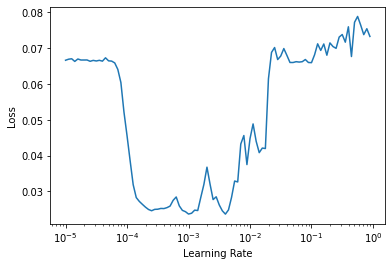

In [19]:
lrs = 1e-5 * (10 ** (np.arange(num_epochs) / 20))
plt.semilogx(lrs, history.history["loss"])
#plt.axis([1e-5,0.9, 0, .2])
plt.ylabel('Loss')
plt.xlabel('Learning Rate')

We can  inspect the lower part of the curve before it gets unstable.
It comes to be 1e-3. We will set the learning rate to be 1e-3 and will compile and train our model in the next steps.


#### Compile and train the model

In [20]:
#num_epochs=30
model=define_rnn_model(allow_cudnn_kernel=True)
optimizer = tf.keras.optimizers.Adam(lr=1e-3)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(noisy_train_patches_seq,
    original_train_patches_seq,
     validation_split=0.2,
     batch_size=batch_size,
    epochs=num_epochs, verbose=1)

Epoch 1/100
13/13 [==============================] - 4s 288ms/step - loss: 0.0670 - val_loss: 0.0769
Epoch 2/100
13/13 [==============================] - 3s 229ms/step - loss: 0.0658 - val_loss: 0.0746
Epoch 3/100
13/13 [==============================] - 3s 232ms/step - loss: 0.0558 - val_loss: 0.0592
Epoch 4/100
13/13 [==============================] - 3s 230ms/step - loss: 0.0424 - val_loss: 0.0398
Epoch 5/100
13/13 [==============================] - 3s 230ms/step - loss: 0.0321 - val_loss: 0.0439
Epoch 6/100
13/13 [==============================] - 3s 230ms/step - loss: 0.0313 - val_loss: 0.0381
Epoch 7/100
13/13 [==============================] - 3s 228ms/step - loss: 0.0260 - val_loss: 0.0346
Epoch 8/100
13/13 [==============================] - 3s 229ms/step - loss: 0.0262 - val_loss: 0.0371
Epoch 9/100
13/13 [==============================] - 3s 228ms/step - loss: 0.0259 - val_loss: 0.0335
Epoch 10/100
13/13 [==============================] - 3s 230ms/step - loss: 0.0253 - val_lo

## Evaluate the model

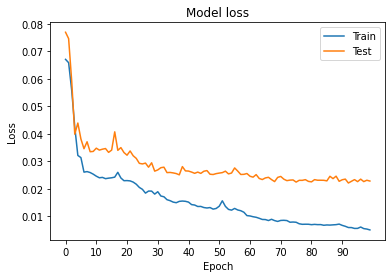

Train Loss: 0.0100, Test Loss: 0.0312


In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.axis([0,100, 0, 0.09])
plt.xticks(np.arange(0, num_epochs, 10))
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

train_loss = model.evaluate(noisy_train_patches_seq,  original_train_patches_seq,verbose=0)
test_loss = model.evaluate(noisy_test_patches_seq,  original_test_patches_seq,verbose=0)
print('Train Loss: %.4f, Test Loss: %.4f' % (train_loss, test_loss))